# Tennis Match Prediction
#### By: Alejandro Velasquez, Chloe Whitaker, Daniel Northcutt, Mason Sherbondy

## Project Goals
- Create a tennis match predictor that will determine the outcome of a match
- Explore and compare the great rivalries of Roger Federer

## Executive Summary 
We discovered:
* Rivals that won half or more meetings with Federer beat him at Grand Slam events
* The surface of the court affects the outcome of players performance
* Players performed differently based on the tourney level
* Higher ranked players win more often (about 64.28% of the time)
* Baseline beat our best model by 6% 
* Features we moved forward with: player_1_rank_points, player_1_hand_R, player_1_hand_L, surface_Clay.

## Initial Questions
- What aspects of the game drive the performance of the players?
- Do Federer's rivalries take a different story at Grand Slam events?
- Do higher ranked players win more?
- Does the court surface matter?

In [1]:
# imports

import pandas as pd
import numpy as np
import regex as re

# Custom Helper Files
from prepare import *
from explore import *
from model import *
import explore1 as e1

# Split 
from sklearn.model_selection import train_test_split

# Stats
from scipy import stats

# Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Remove Limits On Viewing Dataframes
pd.set_option('display.max_columns', None)

## Acquire:

- Data was acquired from repo collecting Men's ATP tennis match data from 1968 - 2019
- https://github.com/JeffSackmann (source)
- Collected 180k rows of data

## ATPTotal Prepare:
- Randomized winner & loser as player1 and player2 alphabetically 
- Set our target to player-1 wins (True or False) for binary classification
- Filtered for matches that took place in the years 1999 all the way up to the end of 2019
- Removed all walkovers, best of 1 matches
- Removed matches where players retired way too early
- Remove records where data was incomplete (extremely small proportion)
- filled in player heights where null
- Set our index to tourney date w/ format to %Y%m%d
- Filtered out players that played less than 50 matches
- Filled mising match time lengths with average match length time for respective tournaments
- 36000 matches

## Data Dictionary
#### DatetimeIndex: 35969 entries, 1999-01-11 to 2019-11-24
 
 |  #  | Column                            |  Non-Null Count | Dtype   | Description
 |:--- |:----------------------------------|:--------------- |:--------|:----------------------------------------------------------------------------------
 | 0   | tourney_id                        |  35969 non-null | object  | Unique identifier for the tournament that the record of match data belongs to.
 | 1   | tourney_name                      |  35969 non-null | object  | Name of the tournament the recorded match belongs to.
 | 2   | surface                           |  35969 non-null | object  | Court construction type - surface material of the court the match is played on.
 | 3   | draw_size                         |  35969 non-null | int64   | Number of players in a tournament rounded to nearest power of 2.
 | 4   | tourney_level                     |  35969 non-null | object  | Level of tournament: G = Grand Slams, M = Masters 1000, A = Other tour level events.
 | 5   | match_num                         |  35969 non-null | int64   | Match specific identifier within the tourney id.
 | 6   | score                             |  35969 non-null | object  | The final results of the match outcome.
 | 7   | best_of                           |  35969 non-null | int64   | The match format. 3 = Best of 3 sets, 5 = Best of 5 sets for the match.
 | 8   | round                             |  35969 non-null | object  | What round the match is in a tournament. RR = Round robin, ER = Early rounds.
 | 9   | minutes                           |  35543 non-null | float64 | Match length.
 | 10  | player_1                          |  35969 non-null | object  | One of the players featured in a match.
 | 11  | player_2                          |  35969 non-null | object  | The other player featured in the match.
 | 12  | player_1_age                      |  35969 non-null | float64 | Age of player 1 at the time of the match.
 | 13  | player_2_age                      |  35969 non-null | float64 | Age of player 2 at the time of the match.
 | 14  | player_1_hand                     |  35969 non-null | object  | Dominant hand for player 1.
 | 15  | player_2_hand                     |  35969 non-null | object  | Dominant hand for player 2.
 | 16  | player_1_ht                       |  35969 non-null | float64 | Height of player 1.
 | 17  | player_2_ht                       |  35969 non-null | float64 | Height of player 2.
 | 18  | player_1_id                       |  35969 non-null | int64   | Unique player identifier for player 1.
 | 19  | player_2_id                       |  35969 non-null | int64   | Unique player identifier for player 2.
 | 20  | player_1_ioc                      |  35969 non-null | object  | Country of origin for player 1.
 | 21  | player_2_ioc                      |  35969 non-null | object  | Country of origin for player 2.
 | 22  | player_1_rank                     |  35952 non-null | float64 | Player 1 rank at the start of the tournament.
 | 23  | player_2_rank                     |  35953 non-null | float64 | Player 2 rank at the start of the tournament.
 | 24  | player_1_rank_points              |  35969 non-null | float64 | Player 1 rank points at the start of the tournament.
 | 25  | player_2_rank_points              |  35969 non-null | float64 | Player 2 rank points at the start of the tournament.
 | 26  | player_1_seed                     |  13218 non-null | float64 | Player 1 seed for the tournament, if seeded.
 | 27  | player_2_seed                     |  14181 non-null | float64 | Player 2 seed for the tournament, if seeded.
 | 28  | player_1_aces                     |  35969 non-null | float64 | Number of serves from player 1 in the match completely untouched by player 2.
 | 29  | player_2_aces                     |  35969 non-null | float64 | Number of serves from player 2 in the match completely untouched by player 1.
 | 30  | player_1_double_faults            |  35969 non-null | float64 | Number of times player 1 failed to start a point by faulting twice (free p2 point).
 | 31  | player_2_double_faults            |  35969 non-null | float64 | Number of times player 2 failed to start a point by faulting twice (free p1 point).
 | 32  | player_1_service_points           |  35969 non-null | float64 | Number of points player 1 played on his serve.
 | 33  | player_2_service_points           |  35969 non-null | float64 | Number of points player 2 played on his serve.
 | 34  | player_1_first_serves_in          |  35969 non-null | float64 | Number of first serves player 1 made.
 | 35  | player_2_first_serves_in          |  35969 non-null | float64 | Number of first serves player 2 made.
 | 36  | player_1_first_serve_points_won   |  35969 non-null | float64 | Number of first serve points won by player 1.
 | 37  | player_2_first_serve_points_won   |  35969 non-null | float64 | Number of first serve points won by player 2.
 | 38  | player_1_second_serve_points_won  |  35969 non-null | float64 | Number of second serve points won by player 1.
 | 39  | player_2_second_serve_points_won  |  35969 non-null | float64 | Number of second serve points won by player 2.
 | 40  | player_1_service_game_total       |  35969 non-null | float64 | Number of games player 1 served in a match.
 | 41  | player_2_service_game_total       |  35969 non-null | float64 | Number of games player 2 served in a match.
 | 42  | player_1_break_points_saved       |  35969 non-null | float64 | Number of points player 1 won to stave off a break of serve.
 | 43  | player_2_break_points_saved       |  35969 non-null | float64 | Number of points player 2 won to stave off a break of serve.
 | 44  | player_1_break_points_faced       |  35969 non-null | float64 | Number of break points player 1 faced.
 | 45  | player_2_break_points_faced       |  35969 non-null | float64 | Number of break points player 2 faced.
 | 46  | winner                            |  35969 non-null | object  | The name of the winner.
 | 47  | player_1_first_serve_%            |  35969 non-null | float64 | Percent of first serves in for player 1.
 | 48  | player_2_first_serve_%            |  35969 non-null | float64 | Percent of first serves in for player 2.
 | 49  | player_1_first_serve_win_%        |  35969 non-null | float64 | Percent of first service points won for player 1.
 | 50  | player_2_first_serve_win_%        |  35967 non-null | float64 | Percent of first service points won for player 2.
 | 51  | player_1_break_points_won         |  35969 non-null | float64 | Number of times player 1 broke player 2's service.
 | 52  | player_2_break_points_won         |  35969 non-null | float64 | Number of times player 2 broke player 2's service.
 | 53  | player_1_wins                     |  35969 non-null | bool    | Target variable. Boolean value that designates whether or not player 1 won the match.
 | 54  | player_2_seeded                   |  35969 non-null | bool    | Boolean value that designates whether or not player 2 is seeded.
 | 55  | player_1_seeded                   |  35969 non-null | bool    | Boolean value that designates whether or not player 1 is seeded.
 | 56  | surface_Carpet                    |  35969 non-null | uint8   | Whether or not the match was played on carpet. 1 = Yes, 0 = No.
 | 57  | surface_Clay                      |  35969 non-null | uint8   | Whether or not the match was played on clay. 1 = Yes, 0 = No.
 | 58  | surface_Grass                     |  35969 non-null | uint8   | Whether or not the match was played on grass. 1 = Yes, 0 = No.
 | 59  | surface_Hard                      |  35969 non-null | uint8   | Whether or not the match was played on hard court. 1 = Yes, 0 = No.
 | 60  | tourney_level_A                   |  35969 non-null | uint8   | Whether or not the tournament was an tour level event. 1 = Yes, 0 = No.
 | 61  | tourney_level_D                   |  35969 non-null | uint8   | Whether or not the tournament was a Davis Cup event. 1 = Yes, 0 = No.
 | 62  | tourney_level_F                   |  35969 non-null | uint8   | Whether or not the tournament was a Tour Finals or season-ending event. 1 = Yes, 0 = No.
 | 63  | tourney_level_G                   |  35969 non-null | uint8   | Whether or not the tournament was a Grand Slam event. 1 = Yes, 0 = No.
 | 64  | tourney_level_M                   |  35969 non-null | uint8   | Whether or not the tournament was a Masters 1000 event. 1 = Yes, 0 = No.
 | 65  | player_1_hand_L                   |  35969 non-null | uint8   | Whether or not player 1 plays left-handed. 1 = Yes, 0 = No.
 | 66  | player_1_hand_R                   |  35969 non-null | uint8   | Whether or not player 1 plays right-handed. 1 = Yes, 0 = No.
 | 67  | player_2_hand_L                   |  35969 non-null | uint8   | Whether or not player 2 plays left-handed. 1 = Yes, 0 = No.
 | 68  | player_2_hand_R                   |  35969 non-null | uint8   | Whether or not player 2 plays right-handed. 1 = Yes, 0 = No.
 | 69  | round_ER                          |  35969 non-null | uint8   | Whether or not the match was in the early rounds. 1 = Yes, 0 = No.
 | 70  | round_F                           |  35969 non-null | uint8   | Whether or not the match was the final round. 1 = Yes, 0 = No.
 | 71  | round_QF                          |  35969 non-null | uint8   | Whether or not the match was a quarter-final. 1 = Yes, 0 = No.
 | 72  | round_R128                        |  35969 non-null | uint8   | Whether or not the match was in the round of 128 1 = Yes, 0 = No.
 | 73  | round_R16                         |  35969 non-null | uint8   | Whether or not the match was in the round of 16. 1 = Yes, 0 = No.
 | 74  | round_R32                         |  35969 non-null | uint8   | Whether or not the match was in the round of 32. 1 = Yes, 0 = No.
 | 75  | round_R64                         |  35969 non-null | uint8   | Whether or not the match was in the round of 64. 1 = Yes, 0 = No.
 | 76  | round_RR                          |  35969 non-null | uint8   | Whether or not the match was a round robin match. 1 = Yes, 0 = No.
 | 77  | round_SF                          |  35969 non-null | uint8   | Whether or not the match was a semifinal. 1 = Yes, 0 = No.
 
Break Point: If a player wins a break point, they win the service game of the opponent.

In [2]:
# pulling function - 35967 matches
df = prepare_atp()
df.shape

(35967, 78)

In [3]:
# confirm prepare
df.head(1)

,tourney_id,tourney_name,surface,draw_size,tourney_level,match_num,score,best_of,round,minutes,player_1,player_2,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_id,player_2_id,player_1_ioc,player_2_ioc,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_seed,player_2_seed,player_1_aces,player_2_aces,player_1_double_faults,player_2_double_faults,player_1_service_points,player_2_service_points,player_1_first_serves_in,player_2_first_serves_in,player_1_first_serve_points_won,player_2_first_serve_points_won,player_1_second_serve_points_won,player_2_second_serve_points_won,player_1_service_game_total,player_2_service_game_total,player_1_break_points_saved,player_2_break_points_saved,player_1_break_points_faced,player_2_break_points_faced,winner,player_1_first_serve_%,player_2_first_serve_%,player_1_first_serve_win_%,player_2_first_serve_win_%,player_1_break_points_won,player_2_break_points_won,player_1_wins,player_1_seeded,player_2_seeded,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,player_1_hand_L,player_1_hand_R,player_2_hand_L,player_2_hand_R,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-11,1999-338,Sydney,Hard,32,A,16,7-6(1) 6-1,3,R32,84.0,Lleyton Hewitt,Patrick Rafter,17.878166,26.036961,R,R,180.0,185.0,103720,102158,AUS,AUS,104.0,4.0,456.0,3315.0,NaN,2.0,2.0,0.0,0.0,5.0,73.0,59.0,51.0,36.0,32.0,24.0,14.0,8.0,10.0,9.0,4.0,3.0,6.0,7.0,Lleyton Hewitt,0.69863,0.610169,0.627451,0.666667,4.0,2.0,True,False,True,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0


In [4]:
# # Pulling Player Database aggregated stats of players within the time span
# PlayerData = pd.read_csv('PlayerData.csv')
# PlayerData.shape

In [5]:
## PlayerDatabase of 371 players that hit a maxrank of at least 100 and have 50 or more games
#PlayerData.head()

In [6]:
# confirm clean
df = clean_for_model(df)

In [7]:
# split the data into train, validate, and test so that we can conform there is not overfitting on our model
train, validate, test = train_validate_test_split(df)

## Explore

### What drives winning? 

Plan for explore:

To identify features to use in modeling, separate the groups by wins / losses and then see if there was a significant difference between variables in that group. For exapmple: I'll take all of the matches that player1 wins and get the mean rank points for player1 for that group then do the same for all of the matches where player1 loses. If there is a significant difference then hight is likely a driver of winning and losing.

In [8]:
# seperate player 1 wins and losses into dfs
player_1_w = train[train['player_1_wins'] == True]
player_1_l = train[train['player_1_wins'] == False]

In [9]:
# confirm wins df
player_1_w.head(1)

,tourney_id,draw_size,winner,surface,tourney_level,best_of,player_1,player_2,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_ioc,player_2_ioc,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_wins,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,player_1_hand_R,player_1_hand_L,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-03-11,2002-404,64,Thomas Enqvist,Hard,M,3,Thomas Enqvist,Thomas Johansson,27.994524,26.965092,R,R,190.0,180.0,SWE,SWE,22.0,9.0,1335.0,2275.0,True,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,22.0,9.0,10.0,1.029432,13.0,-940.0,False,2002


In [10]:
# confirm losses df
player_1_l.head(1)

,tourney_id,draw_size,winner,surface,tourney_level,best_of,player_1,player_2,player_1_age,player_2_age,player_1_hand,player_2_hand,player_1_ht,player_2_ht,player_1_ioc,player_2_ioc,player_1_rank,player_2_rank,player_1_rank_points,player_2_rank_points,player_1_wins,round_ER,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF,player_1_hand_R,player_1_hand_L,tourney_level_A,tourney_level_D,tourney_level_F,tourney_level_G,tourney_level_M,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,winner_rank,loser_rank,ht_diff,age_diff,rank_diff,rank_points_diff,no_upset,year
tourney_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-01-11,1999-338,32,Alex Corretja,Hard,A,3,Albert Costa,Alex Corretja,23.548255,24.752909,R,R,180.0,180.0,ESP,ESP,13.0,3.0,1823.0,3398.0,False,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,3.0,13.0,0.0,-1.204654,10.0,-1575.0,True,1999


#### Does player_1_rank_points impact player_1_wins? 

I will check to see if the average ranking points when player 1 wins is not the same as when player 1 loses.

In [11]:
# Rank points
print('Average rank points, all matches: ' + str(train['player_1_rank_points'].mean()))
print('Average rank points, player 1 wins: ' + str(player_1_w['player_1_rank_points'].mean()))
print('Average rank points, player 1 loses: ' + str(player_1_l['player_1_rank_points'].mean()))
print('\n')

Average rank points, all matches: 1313.2741174718237
Average rank points, player 1 wins: 1597.9916035224248
Average rank points, player 1 loses: 1045.269204819277




It does look like there's a significant difference in the average rank points amongst wins and losses.

I will confirm that with stats and a visual: 

In [12]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "The average ranking points when player 1 wins is the same as when player 1 loses."
alternative_hypothesis = "The average ranking points when player 1 wins is not the same as when player 1 loses." 
alpha = 0.01

In [13]:
get_ttest_rank_points(train)

t = -372780.646
p = 0.000


In [14]:
p = 0.000
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Our evidence does not support the claim that the average ranking points when player 1 wins is not the same as when player 1 loses")


We reject the null hypothesis that The average ranking points when player 1 wins is the same as when player 1 loses.
We move forward with the alternative hypothesis that The average ranking points when player 1 wins is not the same as when player 1 loses.


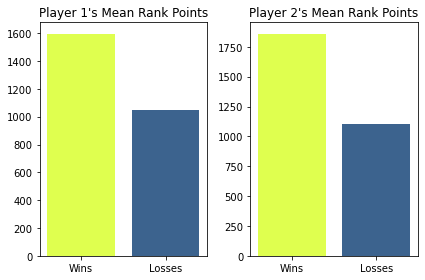

In [15]:
get_winning_player_rank_points(train)

##### Does player_1_hand_R impact player_1_wins?

I will check to see if there is a dependence between right hand used and player 1 winning using stats: 

In [16]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "There is no dependence between right hand used and player 1 winning"
alternative_hypothesis = "There is a dependence between right hand used and player 1 winning"
alpha = 0.05

In [17]:
get_chi_right_hand(train)

chi^2 = 18.3174
p = 0.0000


In [18]:
p = 0.0055
if p < alpha:
    print("We reject the null that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Evidence does not support", alternative_hypothesis)

We reject the null that There is no dependence between right hand used and player 1 winning
We move forward with the alternative hypothesis that There is a dependence between right hand used and player 1 winning


##### Does player_1_hand_L impact player_1_wins?

I will check to see if There is a dependence between left hand used and player 1 winning using stats:

In [19]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "There is no dependence between left hand used and player 1 winning"
alternative_hypothesis = "There is a dependence between left hand used and player 1 winning"
alpha = 0.05

In [20]:
get_chi_left_hand(train)

chi^2 = 18.3174
p = 0.0000


In [21]:
p = 0.0055
if p < alpha:
    print("We reject the null that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Evidence does not support", alternative_hypothesis)

We reject the null that There is no dependence between left hand used and player 1 winning
We move forward with the alternative hypothesis that There is a dependence between left hand used and player 1 winning


##### Does surface_clay impact player_1_wins?

I will check to see if there is a dependence between clay surface used and player 1 winning using stats and a visual.

In [22]:
# We want to be sure that the effect we see isn't explained by chance, so I will use a confidance interval of 95%
# The resulting alpha is .05.
null_hypothesis = "There is no dependence between clay surface and player 1 winning"
alternative_hypothesis = "There is a dependence between clay surface used and player 1 winning"
alpha = 0.05

In [23]:
get_chi_clay(train)

chi^2 = 5.3120
p = 0.0212


In [24]:
p = 0.0032
if p < alpha:
    print("We reject the null that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    print("Evidence does not support", alternative_hypothesis)

We reject the null that There is no dependence between clay surface and player 1 winning
We move forward with the alternative hypothesis that There is a dependence between clay surface used and player 1 winning


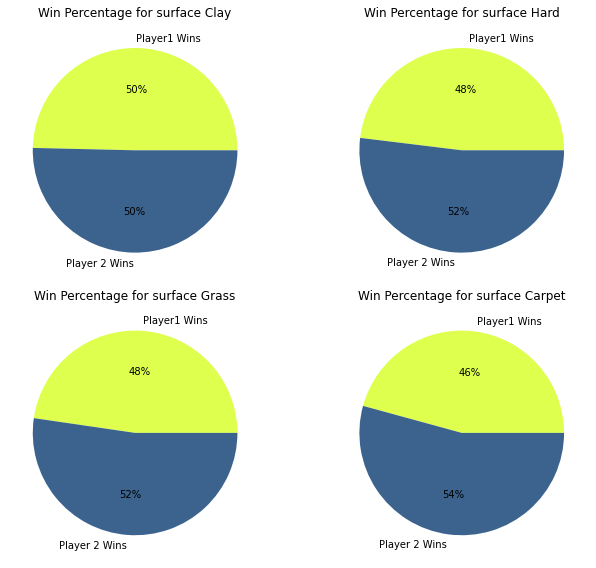

In [25]:
get_pie_surface(train)

### Federer vs the World.

Whatever drives winning, no one can deny that Roger Federer has it in spades (or maybe in rackets). Over the years many have tried to dethrone the man many consider to be the best that ever played the game. Here is a look at Federer compared to some of his top rivals over the past 20 years. 

## Roger Federer vs Andy Roddick

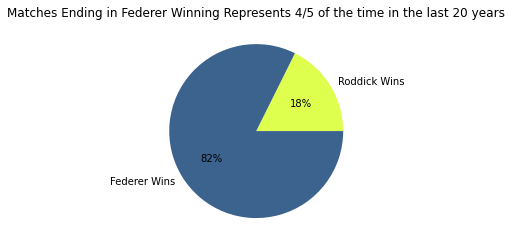

In [26]:
# Roger Federer 14 Wins
# Andy Roddick 3 Wins
e1.get_pie_wins_rod_fed()

#### Federer dominated his rivalry with Roddick.

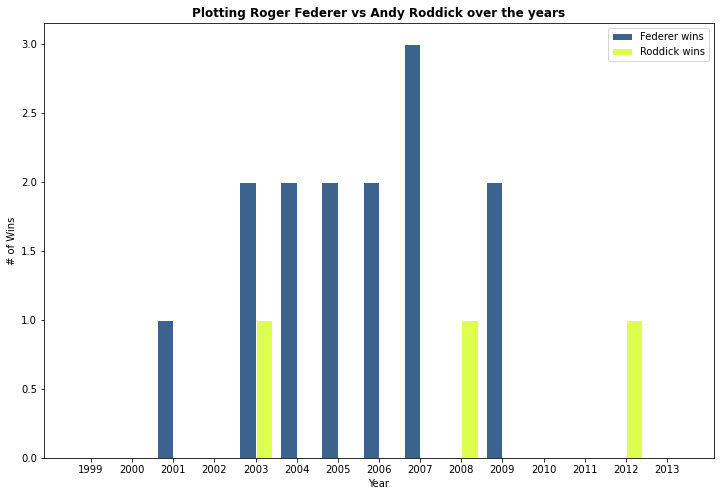

In [27]:
# Showing the rivalry across the multiple years
e1.rod_fed_bar()

#### Roddick found the answers he was looking for on the court with Federer, but these moments were few and far between.

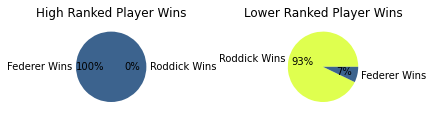

In [28]:
e1.get_pies_upsets_fed_rod()

#### Most of Roddick's wins against Federer were upsets.

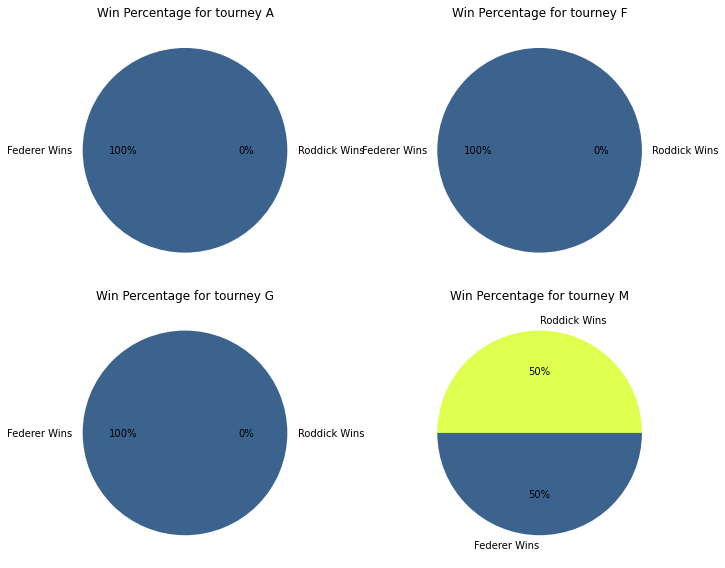

In [29]:
e1.get_pie_tourney_level_fed_rod()

#### Andy Roddick found answers for Federer only in Masters 1000s events. Specifically,  in the 2003 Canada Masters, and in 2008 & 2012 Miami.

## Roger Federer vs Andy Murray

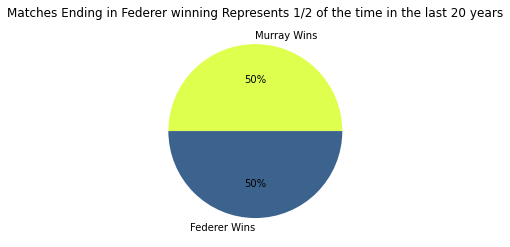

In [30]:
# Roger Federer 10 Wins
# Andy Murray 10 Wins
e1.get_pie_wins_mur_fed()

#### Federer and Murray have split their matchup wins throughout their careers.

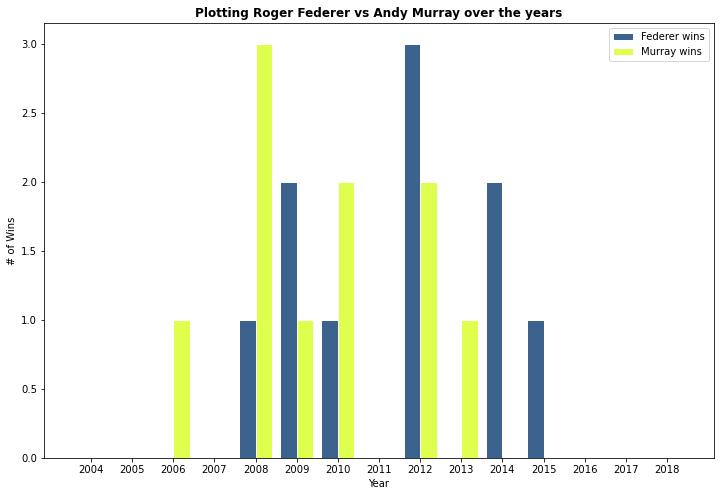

In [31]:
# Showing the rivalry across the multiple years
e1.rod_mur_bar()

#### While Murray did win a lot early meetings, Federer held most of the victories toward the end.

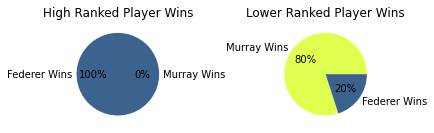

In [32]:
e1.get_pies_upsets_fed_mur()

#### Most of Andy Murray's wins against Federer were upsets.

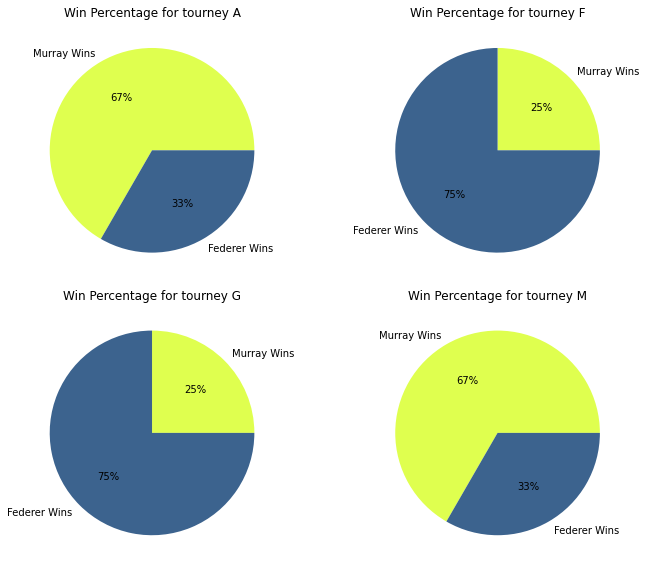

In [33]:
e1.get_pie_tourney_level_fed_mur()

#### While Federer generally dominated Andy Murray at Major (Grand Slam) events, Andy Murray played past the pressure at lower tier events, especially in Masters 1000 tournaments.

## Roger Federer vs Rafael Nadal

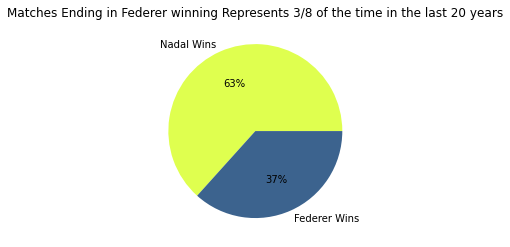

In [34]:
#Roger Federer 11 Wins
#Rafael Federer 19 Wins

e1.get_pie_wins_nad_fed()

#### As spectacular as all of their matches were, Nadal generally dominated Federer throughout his career.

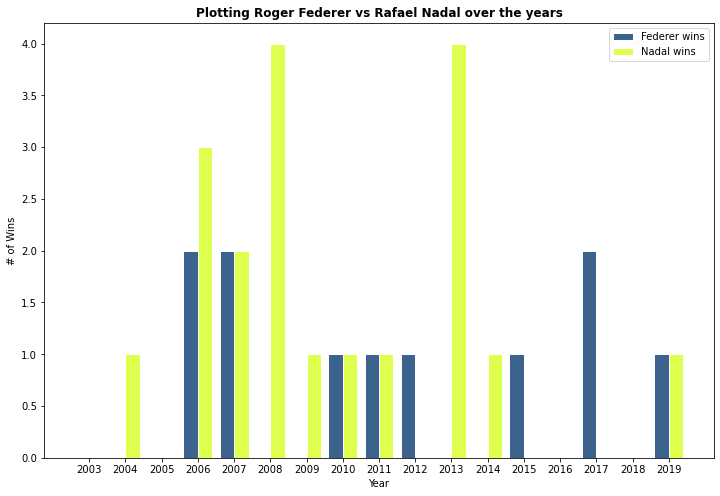

In [35]:
e1.rod_nad_bar()

#### While Nadal did dominate the rivalry over the years, Federer has won the majority of their recent meetings.

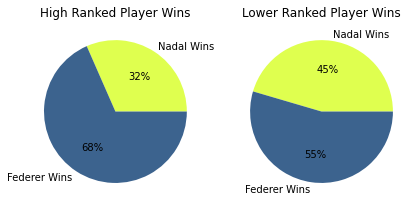

In [36]:
e1.get_pies_upsets_fed_nad()

#### Federer and Nadal both have a fair amount of upset wins between the two, but both players also beat each other quite a few as the favorite.

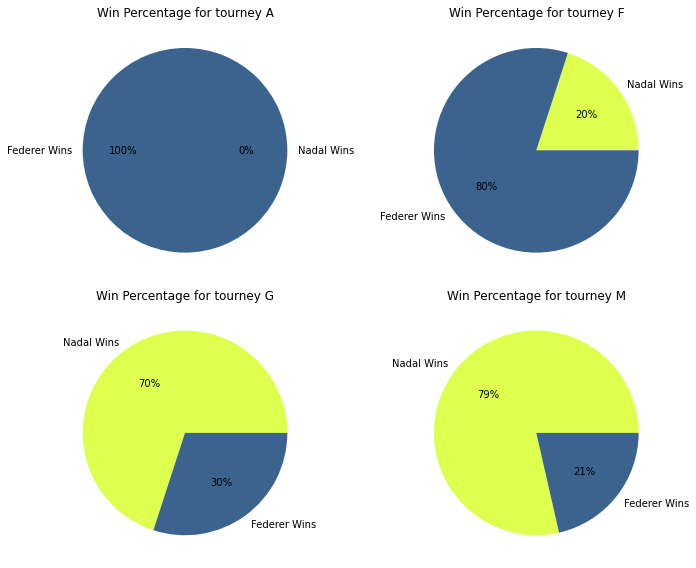

In [37]:
e1.get_pie_tourney_level_fed_nad()

#### Nadal dominated the rivalry on the big stages like Grand Slam events and at Masters 1000s events, but Federer won most of their meetings at the season ending events.

## Roger Federer vs Novak Djokovic

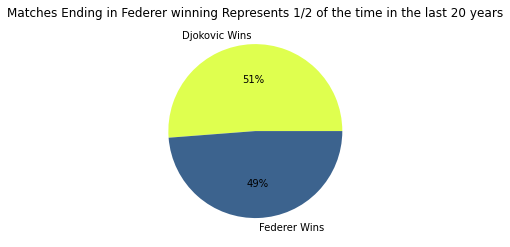

In [38]:
# Roger Federer 11 Wins
# Novak Djokovic 21 Wins
e1.get_pie_wins_djo_fed()

#### Federer and Djokovic have a pretty even amount of wins against each other.

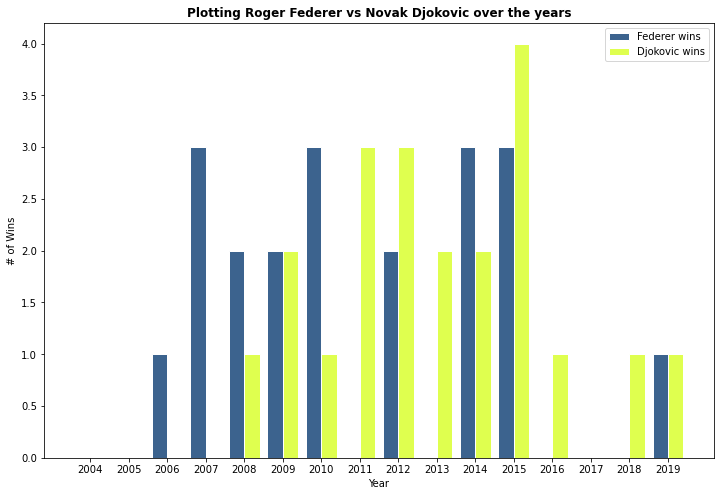

In [39]:
e1.fed_djo_bar()

#### While Federer dominated Djokovic early in the "Djoker's" career, Djokovic has been writing the pages for their meetings more often as of late.

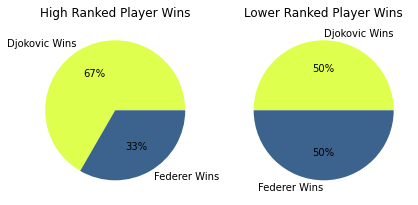

In [40]:
e1.get_pies_upsets_djo_fed()

#### Federer and Djokovic upset each other quite a bit.

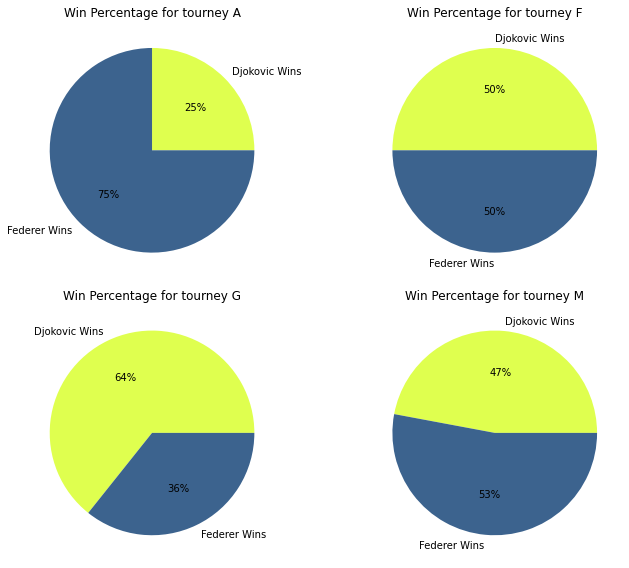

In [41]:
e1.get_pie_tourney_level_fed_djo()

#### Federer won the majority of their matchups at Masters 1000 events, but Djokovic wouldn't let victory go on the biggest of stages; Djokovic has grabbed the majority of their meetings at Majors.

### Explore Summary: 
#### Federer vs. Roddick
* Federer dominated his rivalry with Roddick.
* Roddick found the answers he was looking for on the court with Federer, but these moments were few and far between.
* Most of Roddick's wins against Federer were upsets.
* Andy Roddick found answers for Federer only in Masters 1000s events. Specifically,  in the 2003 Canada Masters, and in 2008 & 2012 Miami.

#### Federer vs. Murray
* Federer and Murray have split their matchup wins throughout their careers.
* While Murray did win a lot early meetings, Federer held most of the victories toward the end.
* Most of Andy Murray's wins against Federer were upsets.
* While Federer generally dominated Andy Murray at Major (Grand Slam) events, Andy Murray played past the pressure at lower tier events, especially in Masters 1000 tournaments.

#### Federer vs. Nadal
* As spectacular as all of their matches were, Nadal generally dominated Federer throughout his career.
* While Nadal did dominate the rivalry over the years, Federer has won the majority of their recent meetings.
* Federer and Nadal both have a fair amount of upset wins between the two, but both players also beat each other quite a few as the favorite.
* Nadal dominated the rivalry on the big stages like Grand Slam events and at Masters 1000s events, but Federer won most of their meetings at the season ending events.

#### Federer vs Djokovic
* Federer and Djokovic have a pretty even amount of wins against each other.
* While Federer dominated Djokovic early in the "Djoker's" career, Djokovic has been writing the pages for their meetings more often as of late.
* Federer and Djokovic upset each other quite a bit.
* Federer won the majority of their matchups at Masters 1000 events, but Djokovic wouldn't let victory go on the biggest of stages; Djokovic has grabbed the majority of their meetings at Majors.

All of these rivalries have been unique. While Federer dominated Roddick throughout his entire career, Nadal dominated Federer earlier on, and Federer has won most of their recent meetings. While Federer split wins evenly with Murray and Djokovic career-total wise, Federer dominated Murray at Grand Slam events while Djokovic took control of most of his Grand Slam meetings with Federer. Nadal, Djokovic and Murray did upset him quite a bit on their paths to world number 1, and the few times Roddick prevailed, they, too, were upsets.

### Features to Move Forward with to Modeling: 

Features to move forward with: player_1_rank_points, player_1_hand_R, player_1_hand_L, surface_Clay.

## Modeling

Before modeling, there a little bit of preparing that needs to happen. For model_prep function see model.py. 

In [42]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model_prep(train,validate,test)

In [43]:
X_train.head(1)

,player_1_rank_points,player_1_hand_R,player_1_hand_L,surface_Clay
0,1823.0,1,0,0


In [44]:
X_train.isnull().sum()

player_1_rank_points    0
player_1_hand_R         0
player_1_hand_L         0
surface_Clay            0
dtype: int64

### Baseline

Creating a baseline to compare the final model preformance to is the last step before modeling. 

The baseline that will be used here is the chance that the highest ranked player will win without an upset.

In [45]:
# look at the uno_pset column
train.no_upset.head(1)

tourney_date
1999-01-11    True
Name: no_upset, dtype: bool

In [46]:
# find the value counts for no_upset
train.no_upset.value_counts(normalize=True)

True     0.637903
False    0.362097
Name: no_upset, dtype: float64

In [47]:
# find the most frequently occurring value in no_upset
baseline = train.no_upset.mode()
baseline

0    True
dtype: bool

In [48]:
# set baseline and check accuracy
match_bsl_prediction = train.no_upset == 1
baseline_accuracy = match_bsl_prediction.mean()
# basline accuracy = 64%%
baseline_accuracy

0.6379027853631896

##### The baseline accuracy is 64%.

### Decision Tree

In [49]:
# get_decision_tree from model.py with a max depth of 3
get_decision_tree(X_train, X_validate, y_train, y_validate)

Accuracy of Decision Tree on train data is 0.5927709646988729
Accuracy of Decision Tree on validate data is 0.5885078776645042


### Random Forest

In [50]:
# get_random_forest from model.py with a max depth of 13 and min samples leaf of 3
get_random_forest(X_train, X_validate, y_train, y_validate)

Accuracy of Random Forest on train is 0.6520033761978055
Accuracy of Random Forest on validate is 0.5673076923076923


### Logistic Regression

In [51]:
# get_log_reg from model.py with c = 9
get_log_reg(X_train, X_validate, y_train, y_validate)

Accuracy of Logistic Regression on train is 0.588103867732486
Accuracy of Logistic Regression on validate is 0.5856116774791473


##### best model = logistic regression with an accuracy on validate date of 59%.

## Conclusion 
* Rivals that won half or more meetings with Federer beat him at Grand Slam events
* The surface of the court affects the outcome of players performance
* Players performed differently based on the tourney level
* Higher ranked players win more often (about 64.28% of the time)
* Baseline beat our best model by 6%

## Next Steps

- Create a model to predict if a player will reach the top 30 ranking by evaluating their first 50 games
- Filter for players that hit a max rank of 100 or better
- Aggregate full stats for Aces, Breakpoints, Double Faults, Wins, and First Serve Win by Match
- Aggregate career performance by court surface (hard, grass, clay, carpet)
- Aggregate first 50 matches statistics - later use to predict future ranking

### Questions for our further exploration:
- Does a difference in career average break points won impact victory?

- Does a difference in career average break points saved impact victory?

- What characteristics and trends determine a player to become a top 30?

- Does surface performance predict a player's future rank?

- Does a difference in career percent-of-break-points-won impact victory?